## Momentum Signals  
08/20/2024 | Fang Chen

In [1]:
import yfinance as yf

import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

import pandas as pd
import numpy as np
import datetime as dt
pd.options.display.max_columns = 50
# import sklearn
# import pylab as pl
%matplotlib inline

In [2]:
# Parse csv for tickers
all_tickers = pd.read_csv('tickers.csv')
djia_tickers = pd.read_csv('djia_tickers.csv')

In [3]:
# Get data
daily = pd.concat([yf.Ticker(t).history(period="10y").reset_index().assign(Ticker=t) for t in djia_tickers.Ticker], ignore_index=True)
spxt = yf.Ticker('SPXT').history(period="10y").reset_index().assign(Ticker='SPXT')
djia = yf.Ticker('DJI').history(period="10y").reset_index().assign(Ticker='DJI')


In [4]:
# Reset data without querying (slower)
data = daily.copy()
data

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Ticker
0,2014-08-25 00:00:00-04:00,22.595016,22.679367,22.481808,22.539522,161080000,0.0,0.0,AAPL
1,2014-08-26 00:00:00-04:00,22.512886,22.530645,22.388580,22.395239,132608000,0.0,0.0,AAPL
2,2014-08-27 00:00:00-04:00,22.424096,22.768161,22.353063,22.670490,209476000,0.0,0.0,AAPL
3,2014-08-28 00:00:00-04:00,22.550625,22.814778,22.543966,22.697130,273840000,0.0,0.0,AAPL
4,2014-08-29 00:00:00-04:00,22.832527,22.841406,22.686021,22.752615,178380000,0.0,0.0,AAPL
...,...,...,...,...,...,...,...,...,...
71839,2024-08-19 00:00:00-04:00,54.000000,54.139999,53.570000,53.650002,2096000,0.0,0.0,DOW
71840,2024-08-20 00:00:00-04:00,53.529999,53.549999,52.540001,52.720001,4391500,0.0,0.0,DOW
71841,2024-08-21 00:00:00-04:00,53.000000,53.119999,52.810001,52.950001,2809500,0.0,0.0,DOW
71842,2024-08-22 00:00:00-04:00,53.110001,53.179001,52.494999,52.560001,2916000,0.0,0.0,DOW


In [5]:
start_date = '2023-01-01'
end_date = dt.datetime.today()
type_choices = ['absolute', 'pivoted']
momentum_type = type_choices[0] 
last_daily = pd.to_datetime( data.Date.max() )
next_mon = (last_daily + pd.DateOffset(months=1)).replace(day=1)

In [6]:
ref_dates = [last_daily - pd.DateOffset(months=n) for n in [1,3,6,12]]
ref_dates = [data[data.Date <= d].Date.max() for d in ref_dates]

data['daily return'] = data.Close / data.groupby('Ticker').Close.shift(periods=1) - 1

if momentum_type == 'pivoted':

### Period to Date Momentum 

    data = data.merge(data.loc[data.Date == ref_dates[0]] [['Ticker', 'Close']], how='left', on='Ticker', 
                      suffixes = [None, '_1m'])
    data = data.merge(data.loc[data.Date == ref_dates[1]] [['Ticker', 'Close']], how='left', on='Ticker', 
                      suffixes = [None, '_3m'])
    data = data.merge(data.loc[data.Date == ref_dates[2]] [['Ticker', 'Close']], how='left', on='Ticker', 
                      suffixes = [None, '_6m'])
    data = data.merge(data.loc[data.Date == ref_dates[3]] [['Ticker', 'Close']], how='left', on='Ticker', 
                      suffixes = [None, '_1y'])
    
    data['momentum_1m'] = data['Close'] / data['close_1m'] - 1
    data['momentum_3m'] = data['Close'] / data['close_3m'] - 1
    data['momentum_6m'] = data['Close'] / data['close_6m'] - 1
    data['momentum_1y'] = data['Close'] / data['close_1y'] - 1
    
    data.loc[data['Date'] < ref_dates[0], 'momentum_1m'] = np.nan
    data.loc[data['Date'] < ref_dates[1], 'momentum_3m'] = np.nan
    data.loc[data['Date'] < ref_dates[2], 'momentum_6m'] = np.nan
    data.loc[data['Date'] < ref_dates[3], 'momentum_1y'] = np.nan

else:

### Absolute Momentum

    data['momentum_1m'] = data.Close / data.groupby('Ticker').Close.shift(periods=21) -1
    data['momentum_3m'] = data.Close / data.groupby('Ticker').Close.shift(periods=63) -1
    data['momentum_6m'] = data.Close / data.groupby('Ticker').Close.shift(periods=126) -1
    data['momentum_1y'] = data.Close / data.groupby('Ticker').Close.shift(periods=252) -1

data['pct_rank_1m'] = data.groupby('Date').momentum_1m.rank(pct=True)
data['pct_rank_3m'] = data.groupby('Date').momentum_3m.rank(pct=True)
data['pct_rank_6m'] = data.groupby('Date').momentum_6m.rank(pct=True)
data['pct_rank_1y'] = data.groupby('Date').momentum_1y.rank(pct=True)

In [7]:
### Custom Period to Date Momentum

'''
Params: datetime <ref_date>, period start date where momentum=0
Return: pd.DataFrame, containing close_period (original closing px), momentum_period (rolling return)
'''

def get_piv_mom_period(ref_date, fillNan=False): 
    
    if fillNan:
        custom_data = data.merge(data.loc[data.Date >= ref_date].groupby('Ticker').Close.first(), how='left', on='Ticker', 
                                 suffixes = [None,'_period'])
    else:
        custom_data = data.merge(data.loc[data.Date == ref_date] [['Ticker', 'Close']], how='left', on='Ticker', 
                                 suffixes = [None, '_period'])
    custom_data['momentum_period'] = custom_data.Close / custom_data['Close_period'] - 1
    custom_data['pct_rank_period'] = custom_data.groupby('Date').momentum_period.rank(pct=True)
    
    custom_data.loc[custom_data['Date'] < ref_date, 'momentum_period'] = np.nan
    custom_data.loc[custom_data['Date'] < ref_date, 'pct_rank_period'] = np.nan
    return custom_data
    
alltime = get_piv_mom_period(data[data.Date >= start_date].Date.min(), fillNan=True)  ## WILL ALWAYS BE PIVOTED TO START OF RECORD
    
def get_mom_period(business_days = 63, exclude = 0): 
    custom_data = data.copy()
    custom_data['momentum_period'] = custom_data.Close.shift(periods=exclude) / data.groupby('Ticker').Close.shift(periods=business_days) - 1
    custom_data['pct_rank_period'] = custom_data.groupby('Date').momentum_period.rank(pct=True)
    custom_data['increment'] = 1
    return custom_data

The following graph is to check whether or not the table calculations are correct as well as demonstrate the returns of buying in at certain points in time.

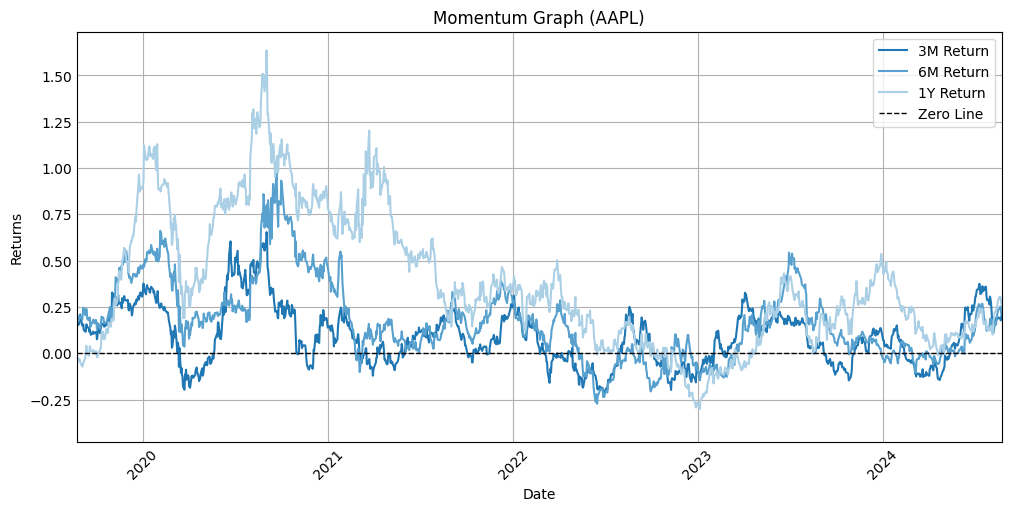

In [8]:
inp = data.loc[data.Ticker == 'AAPL']
# inp = data.groupby('Date').agg({'momentum_1m': 'mean', 'momentum_3m': 'mean', 'momentum_6m': 'mean'}).reset_index()
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')

# ax.plot(inp.Date, inp['momentum_1m'], label='1M Return')
ax.plot(inp.Date, inp['momentum_3m'], label='3M Return')
ax.plot(inp.Date, inp['momentum_6m'], label='6M Return')
ax.plot(inp.Date, inp['momentum_1y'], label='1Y Return')

ax.set(xlim=(last_daily - pd.DateOffset(years=5), last_daily))

# Add title and labels
ax.set_title('Momentum Graph (AAPL)')
ax.set_xlabel('Date')
ax.set_ylabel('Returns')
ax.axhline(0, color='black', linewidth=1, linestyle='--', label='Zero Line')

ax.legend()
ax.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

## Long-only Momentum Trading Strategy

The following exploratory strategy is investing equal weights to the top (or bottom) quartiles of long- and short-term momentum signals. In other words, invest in the high performers, and hold these securities until present day to calculate the return for each set of investments. Assuming the same weight for each security for simplicity, the sum of these returns represent the net return for this long strategy.

In [9]:
portfolio = pd.DataFrame(data.Ticker.unique())
portfolio.rename(columns={0: 'Ticker'}, inplace=True)
portfolio.set_index('Ticker', inplace=True)
portfolio['shares'] = 0
portfolio['net_exposure'] = 0.0
# portfolio['new_shares'] = 0
# portfolio['net_return'] = 0.0

In [10]:
buckets = [0, 0.25, 0.5, 0.75, 1]
labels = ['0-25th Pct', '25-50th Pct', '50-75th Pct', '75-100th Pct']

# Add a new column for the group based on percentile rank
data['rank_group'] = pd.cut(data['pct_rank_3m'], bins=buckets, labels=labels)

'''
Params: datetime <buy_date>, purchase date
        pd.DataFrame <portfolio_df>, portfolio with all shares purchased
        pd.DataFrame <temp_df>, containing 'rank_group' corresponding to <labels> variable
        dtype of 'rank_group' <signal>, optional, wanted option of 'rank_group'
Return: pd.DataFrame, portfolio with all shares purchased based on signal
'''
def buy_highest_mom(buy_date, portfolio_df, temp_df, 
                    signal = labels[-1], weigh_on=False, sell = False):
    # print(signal)
    for index, row in temp_df.loc[temp_df.Date == buy_date].iterrows():
        if row['rank_group'] == signal:
            ## Could modify to buying equal $ rather than shares
            # portfolio_df.loc[row['Ticker'], 'new_shares'] += 1
            if weigh_on == True:
                if sell:
                    portfolio_df.loc[row['Ticker'], 'shares'] -= row['increment']
                    portfolio_df.loc[row['Ticker'], 'net_exposure'] -= row.Close * row['increment']
                else:
                    portfolio_df.loc[row['Ticker'], 'shares'] += row['increment']
                    portfolio_df.loc[row['Ticker'], 'net_exposure'] += row.Close * row['increment']
            else:
                if sell:
                    portfolio_df.loc[row['Ticker'], 'shares'] -= 1
                    portfolio_df.loc[row['Ticker'], 'net_exposure'] += row.Close
                else: 
                    portfolio_df.loc[row['Ticker'], 'shares'] -= 1
                    portfolio_df.loc[row['Ticker'], 'net_exposure'] += row.Close
    total_shares = portfolio_df.shares.sum()
    portfolio_df['weight'] = portfolio_df.shares / total_shares

    return portfolio_df

In [11]:
'''
Params: datetime <buy_date>, purchase date
        pd.DataFrame <portfolio_df>, portfolio with all shares purchased
        datetime <ret_date>, optional, date to record returns
Return: pd.DataFrame, return_stream of portfolio_df
'''
def calculate_returns(buy_date, portfolio_df, ret_date= last_daily): 
    ret_stream_dates = []
    ret_stream = []
    last_iter = data[data.Date <= ret_date].Date.max()
    prev_date_ptr = buy_date
    buy_date = buy_date #+ pd.DateOffset(months=1)
    date_ptr = data[data.Date <= buy_date].Date.max() 
    
    while (date_ptr < last_iter):
        portfolio_df = portfolio_df.merge(data.loc[data.Date == prev_date_ptr][['Ticker', 'Close']], how='left', on='Ticker')
        portfolio_df = portfolio_df.merge(data.loc[data.Date == date_ptr][['Ticker', 'Close']], how='left', on='Ticker')
        portfolio_df['weighted_return'] = (portfolio_df['Close_y'] / portfolio_df['Close_x'] -1) * portfolio_df.weight
        ret_stream_dates.append(date_ptr)
        ret_stream.append(portfolio_df.weighted_return.sum())
        portfolio_df.drop(['weighted_return', 'Close_x', 'Close_y'], axis=1, inplace=True)
        
        prev_date_ptr = date_ptr
        buy_date = buy_date + pd.DateOffset(months=1)
        date_ptr = data[data.Date <= buy_date].Date.max()   
    
    return pd.DataFrame({"EOMonth": ret_stream_dates, "Monthly Return": ret_stream})     



In [12]:
## SINGLE DAY TESTING

buy_date = pd.to_datetime('2024-01-01').tz_localize('America/New_York')
back_date = buy_date - pd.DateOffset(months=1)   ## YTD

buy_date = data[data.Date <= buy_date].Date.max()
back_date = data[data.Date >= back_date].Date.min()

# print(buy_date)
# print(back_date)

if momentum_type == 'pivoted':
    test = get_piv_mom_period(back_date) ## Buy based on highest momentum YTD
else:
    test = get_mom_period(63) ## Buy based on highest 3-Month momentum
    
test['rank_group'] = pd.cut(test['pct_rank_period'], bins=buckets, labels=labels)

fund = buy_highest_mom(buy_date, portfolio.copy(), test)
# print(fund)
ret_stream = calculate_returns(buy_date, fund) 
ret_stream



,EOMonth,Monthly Return
0,2023-12-29 00:00:00-05:00,0.000000
1,2024-01-29 00:00:00-05:00,0.012600
2,2024-02-29 00:00:00-05:00,0.028968
3,2024-03-28 00:00:00-04:00,0.018407
4,2024-04-29 00:00:00-04:00,-0.057665
5,2024-05-29 00:00:00-04:00,0.004732
6,2024-06-28 00:00:00-04:00,0.021176
7,2024-07-29 00:00:00-04:00,0.009251


In [13]:
## Buy based on HIGHEST ABSOLUTE Momentum

if (momentum_type == 'absolute'):

    buy_date = pd.to_datetime('2020-01-01').tz_localize('America/New_York')
    buy_date = data[data.Date <= buy_date].Date.max()
    
    ## TESTS -- Comment out for experimenting
    sig = labels[-1]
    fund = portfolio.copy()

    # test = get_mom_period(63) ## Buy based on highest 3-Month momentum    
    # test['rank_group'] = pd.cut(test['pct_rank_period'], bins=buckets, labels=labels)
    # fund = buy_highest_mom(buy_date, fund, test, signal=sig)

    # test = get_mom_period(126) ## Buy based on highest 6-Month momentum    
    # test['rank_group'] = pd.cut(test['pct_rank_period'], bins=buckets, labels=labels)
    # fund = buy_highest_mom(buy_date, fund, test, signal=sig)

    test = get_mom_period(252) ## Buy based on highest 12-Month momentum
    test['rank_group'] = pd.cut(test['pct_rank_period'], bins=buckets, labels=labels)
    fund = buy_highest_mom(buy_date, fund, test, signal=sig)
    
    # test = get_mom_period(252, exclude=21) ## Buy based on highest 12-Month momentum (w/o reversal)
    # test['rank_group'] = pd.cut(test['pct_rank_period'], bins=buckets, labels=labels)
    # fund = buy_highest_mom(buy_date, fund, test, signal=sig)

    # print(fund)
    ret_stream = calculate_returns(buy_date, fund)
    # print(ret_stream) 
    ret_date = pd.to_datetime('2021-01-01').tz_localize('America/New_York')
    ret_date = ret_stream[ret_stream.EOMonth <= ret_date].EOMonth.max()

    ret_stream['Cumulative Return'] = (ret_stream['Monthly Return']+1).cumprod() - 1
    sample_ret = ret_stream.loc[ret_stream.EOMonth == ret_date].groupby('EOMonth').last()['Cumulative Return'].sum()
    print(f"Return from {buy_date.date()} to {ret_date.date()}: ", sample_ret)

Return from 2019-12-31 to 2020-12-29:  0.2918225346083989


The highest return for 2020 is with tickers with the highest 1-year momentum. These equities far outperformed the market. Note that this portfolio only consists of ~7 stocks as the sample is the DJIA tickers, which also means that this strategy carries a high risk from lack of diversification. To actually apply this would require much more out-sample testing.

In [14]:
## Compare with S&P Return (rfr, from start to ret_date)
spxt_ret = spxt.loc[spxt.Date == buy_date, 'Close'].sum()
spxt_ret2 = spxt.loc[spxt.Date == ret_date, 'Close'].sum()
spxt_ret = spxt_ret2 / spxt_ret -1
print('S&P Return Period: ', spxt_ret)
spxt['Daily Ret'] = spxt.Close / spxt.Close.shift(periods=1) - 1

index = spxt.loc[spxt.Date >= buy_date].copy()
index['Cumulative Return'] = (index['Daily Ret'] + 1).cumprod() - 1
index = index.groupby(index.Date + pd.offsets.MonthEnd(0)).last()

## Compare with DJIA
djia_ret = data.loc[data.Date == buy_date, 'Close'].sum()/ 0.14036
djia_ret2 = data.loc[data.Date == ret_date, 'Close'].sum()/ 0.14036
djia_ret = djia_ret2 / djia_ret -1
print('DJIA Return Period: ', djia_ret)

# djia_ret = djia.loc[djia.Date == buy_date, 'Close'].sum() ## Data not found
# djia_ret2 = djia.loc[djia.Date == ret_date, 'Close'].sum()
# print(djia_ret2)

# djia_ret = djia_ret2 / djia_ret -1
# print('DJIA Return Period: ', djia_ret)



S&P Return Period:  0.09459463380141986
DJIA Return Period:  0.12029648475665677


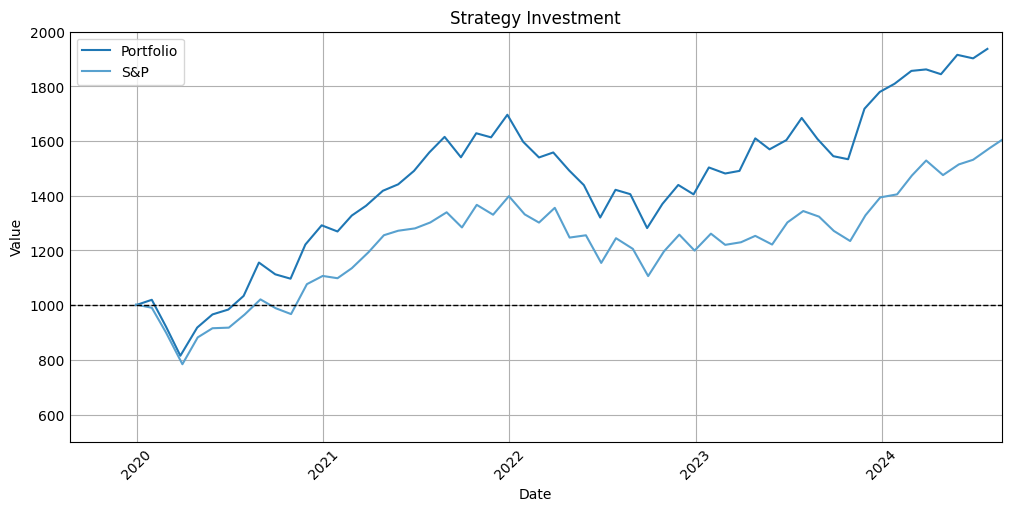

In [15]:
inp = ret_stream
inp2 = index

# inp = data.groupby('Date').agg({'momentum_1m': 'mean', 'momentum_3m': 'mean', 'momentum_6m': 'mean'}).reset_index()
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')

# ax.plot(inp.Date, inp['momentum_1m'], label='1M Return')
ax.plot(inp.EOMonth, 1000*(1+ inp['Cumulative Return']), label='Portfolio')
ax.plot(inp2.Date, 1000*(1+ inp2['Cumulative Return']), label='S&P')

ax.set(xlim=(last_daily - pd.DateOffset(years=5), last_daily),
       ylim=(500, 2000))

# Add title and labels
ax.set_title('Strategy Investment')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.axhline(1000, color='black', linewidth=1, linestyle='--')

ax.legend()
ax.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

In [16]:
def stats(ret_stream):
  mean_return = ret_stream['Monthly Return'].mean()
  mean_return_annual = (1+mean_return)**(12) -1
  volatility = ret_stream['Monthly Return'].std()
  volatility_annual = volatility * np.sqrt(12)
  sharpe = mean_return_annual/volatility_annual
  count_months = ret_stream.EOMonth.count()
  hit_months = ret_stream.loc[ret_stream['Monthly Return'] > 0].EOMonth.count()
  hit_rate = hit_months/count_months
  
  ret_stream['Max Cumulative Return'] = 1+ret_stream['Cumulative Return'].cummax()
  ret_stream['Drawdowns'] = (1+ret_stream['Cumulative Return'] - ret_stream['Max Cumulative Return']) / ret_stream['Max Cumulative Return']
  max_drawdown = ret_stream['Drawdowns'].min()

  highest_monthly_gain = (1+ ret_stream['Monthly Return'].max())**12 -1
  worst_monthly_loss = (1+ ret_stream['Monthly Return'].min())**12 -1

  ret_skew = ret_stream['Monthly Return'].skew()
  

  return {"mean_return_annualized": mean_return_annual,
          "volatility_annualized": volatility_annual,
          "sharpe_ratio": sharpe,
          "hit_rate":  hit_rate,
          "max_drawdown": max_drawdown,
          "highest_gain_annualized": highest_monthly_gain,
          "worst_loss_annualized": worst_monthly_loss,
          "return_skewness": ret_skew
          }

statistics = stats(ret_stream.loc[ret_stream.EOMonth != buy_date].copy())
for item in statistics:
  print(item, ": ", statistics[item])

mean_return_annualized :  0.17486363778842606
volatility_annualized :  0.18733187344682284
sharpe_ratio :  0.9334430632172368
hit_rate :  0.6
max_drawdown :  -0.24432664318329925
highest_gain_annualized :  3.172844448579073
worst_loss_annualized :  -0.7683270459610997
return_skewness :  -0.10243157701774218


The following is a revised version of the previous strategy: added rank-based weighting, "sell"/remove low 3-month momentum from portfolio of high 1-yr momentum.

In [17]:
## Use these variables for backtesting
x ='2018-01-01'
y ='2024-01-01'

def create_portfolio(x=x, y=y):  ## Start and end of period

    buy_date = pd.to_datetime(x).tz_localize('America/New_York')
    buy_date = data[data.Date <= buy_date].Date.max()
        
    buckets = [0, 0.25, 0.5, 0.75, 1]
    labels = ['0-25th Pct', '25-50th Pct', '50-75th Pct', '75-100th Pct']
    buckets2 = [0, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
    amounts = [0, 1, 2, 3, 4, 5]
       
    sig = labels[-1]
    fund = portfolio.copy()
    
    test_lows = get_mom_period(63) ## Buy based on highest 3-Month momentum    
    test_lows['rank_group'] = pd.cut(test_lows['pct_rank_period'], bins=buckets, labels=labels)
    # fund = buy_highest_mom(buy_date, fund, test, signal=sig)

    test = get_mom_period(252) ## Buy based on highest 12-Month momentum
    test['rank_group'] = pd.cut(test['pct_rank_period'], bins=buckets, labels=labels)
    test['increment'] = pd.cut(test['pct_rank_period'], bins=buckets2, labels=amounts)
    fund = buy_highest_mom(buy_date, fund, test, signal=sig, weigh_on=True)

    ## Selling low 3-month momentum
    fund = buy_highest_mom(buy_date, fund, test_lows, signal=labels[0],sell=True)

    print("Total portfolio weight: ", fund.weight.sum().round(4))

    # print(fund)

    ret_stream = calculate_returns(buy_date, fund)
    ret_date = pd.to_datetime(y).tz_localize('America/New_York')
    ret_date = ret_stream[ret_stream.EOMonth <= ret_date].EOMonth.max()

    ret_stream['Cumulative Return'] = (ret_stream['Monthly Return']+1).cumprod() - 1
    sample_ret = ret_stream.loc[ret_stream.EOMonth == ret_date].groupby('EOMonth').last()['Cumulative Return'].sum()
    print(f"Return from {buy_date.date()} to {ret_date.date()}: ", sample_ret)

    ## Compare with S&P Return (from start to ret_date)
    spxt_ret = spxt.loc[spxt.Date == buy_date, 'Close'].sum()
    spxt_ret2 = spxt.loc[spxt.Date == ret_date, 'Close'].sum()
    spxt_ret = spxt_ret2 / spxt_ret -1
    print('S&P Return Period: ', spxt_ret)
    spxt['Daily Ret'] = spxt.Close / spxt.Close.shift(periods=1) - 1

    ## Compare with DJIA
    djia_ret = data.loc[data.Date == buy_date, 'Close'].sum()/ 0.14036
    djia_ret2 = data.loc[data.Date == ret_date, 'Close'].sum()/ 0.14036
    djia_ret = djia_ret2 / djia_ret -1
    print('DJIA Return Period: ', djia_ret)

    return [ret_stream, buy_date]

In [18]:
# Testing with constant start date 
print("CONSTANT START DATES ===================\n")
for n in range(19, 25):
  create_portfolio('2018-01-01', f'20{n}-01-01')
  print()

# Testing in one year intervals
print("ONE YEAR INTERVALS ===================\n")
for n in range(18, 24):
  create_portfolio(f'20{n}-01-01', f'20{n+1}-01-01')
  print()


CONSTANT START DATES ===================

Total portfolio weight:  1.0
Return from 2017-12-29 to 2018-12-28:  0.11530342865559473
S&P Return Period:  -0.07472904997125429
DJIA Return Period:  0.002269582987802332

Total portfolio weight:  1.0
Return from 2017-12-29 to 2019-12-27:  0.45602119810795894
S&P Return Period:  0.18274267391882693
DJIA Return Period:  0.30282824359154015

Total portfolio weight:  1.0
Return from 2017-12-29 to 2020-12-28:  1.0754023259737613
S&P Return Period:  0.29122108385224665
DJIA Return Period:  0.45450904128053526

Total portfolio weight:  1.0
Return from 2017-12-29 to 2021-12-28:  1.2108921526815424
S&P Return Period:  0.643277651874482
DJIA Return Period:  0.7776216041426058

Total portfolio weight:  1.0
Return from 2017-12-29 to 2022-12-28:  0.4920375596877278
S&P Return Period:  0.39575883195192674
DJIA Return Period:  0.6210896388909537

Total portfolio weight:  1.0
Return from 2017-12-29 to 2023-12-28:  1.6528495867901207
S&P Return Period:  0.6456

SINGLE PERIOD ===================

Total portfolio weight:  1.0
Return from 2015-12-31 to 2024-07-26:  2.463670530799301
S&P Return Period:  1.3606723886675058
DJIA Return Period:  2.1296230424520557

mean_return_annualized :  0.182553105489778
volatility_annualized :  0.2188508400902318
sharpe_ratio :  0.8341439558308831
hit_rate :  0.5533980582524272
max_drawdown :  -0.45001868562926
highest_gain_annualized :  10.627227523184425
worst_loss_annualized :  -0.8582660206945609
return_skewness :  0.3079133817888212


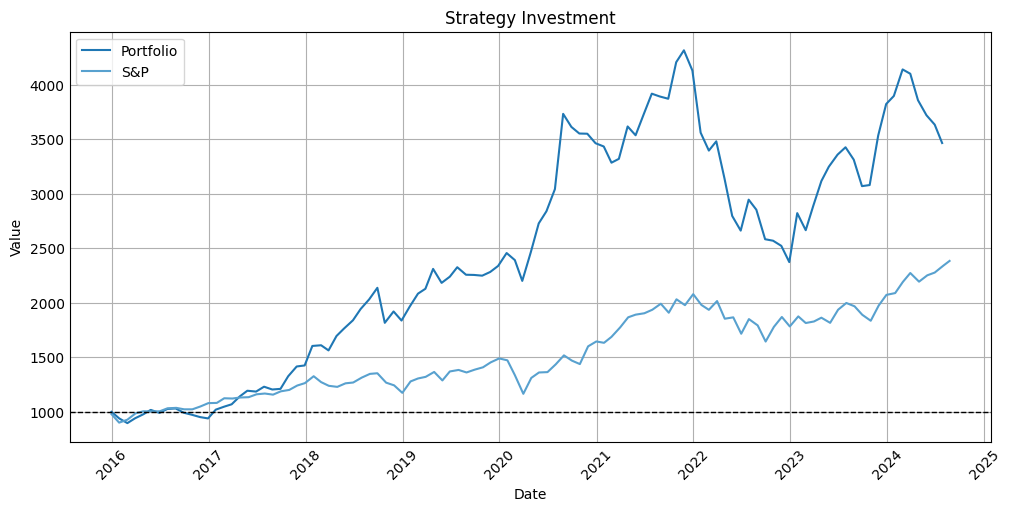

In [19]:
# Testing single period
print("SINGLE PERIOD ===================\n")
ret_stream = create_portfolio("2016-01-01", "2024-08-01")
buy_date = ret_stream[1]
ret_stream = ret_stream[0]
print()

index = spxt.loc[spxt.Date >= buy_date].copy()
index['cum_ret_spxt'] = (index['Daily Ret'] + 1).cumprod() - 1
index = index.groupby(index.Date + pd.offsets.MonthEnd(0)).last()
index['monthly'] = (1+ index['cum_ret_spxt']) / (1+index['cum_ret_spxt'].shift(1)) -1


statistics = stats(ret_stream.loc[ret_stream.EOMonth != buy_date].copy())
for item in statistics:
  print(item, ": ", statistics[item])
  
inp = ret_stream
inp2 = index

# inp = data.groupby('Date').agg({'momentum_1m': 'mean', 'momentum_3m': 'mean', 'momentum_6m': 'mean'}).reset_index()
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')

# ax.plot(inp.Date, inp['momentum_1m'], label='1M Return')
ax.plot(inp.EOMonth, 1000*(1+ inp['Cumulative Return']), label='Portfolio')
ax.plot(inp2.Date, 1000*(1+ inp2['cum_ret_spxt']), label='S&P')

# ax.set(xlim=(last_daily - pd.DateOffset(years=5), last_daily),
#        ylim=(500, 2000))

# Add title and labels
ax.set_title('Strategy Investment')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.axhline(1000, color='black', linewidth=1, linestyle='--')

ax.legend()
ax.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()

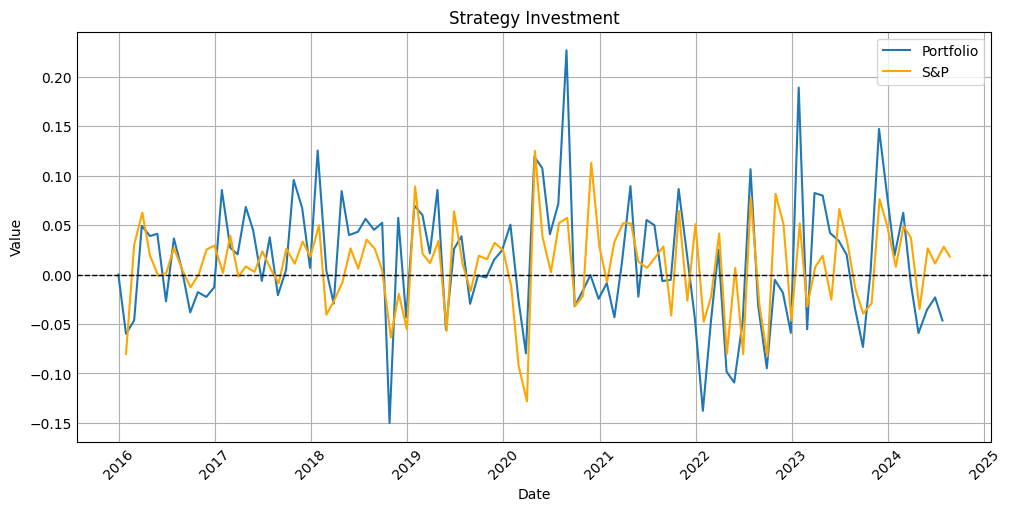

In [20]:
inp = ret_stream
inp2 = index

# inp = data.groupby('Date').agg({'momentum_1m': 'mean', 'momentum_3m': 'mean', 'momentum_6m': 'mean'}).reset_index()
fig, ax = plt.subplots(figsize=(10, 5), layout='constrained')

# ax.plot(inp.Date, inp['momentum_1m'], label='1M Return')
ax.plot(inp.EOMonth, inp['Monthly Return'], label='Portfolio')
ax.plot(inp2.Date, inp2['monthly'], label='S&P', color='orange')

# ax.set(xlim=(last_daily - pd.DateOffset(years=5), last_daily),
#        ylim=(500, 2000))

# Add title and labels
ax.set_title('Strategy Investment')
ax.set_xlabel('Date')
ax.set_ylabel('Value')
ax.axhline(0, color='black', linewidth=1, linestyle='--')

ax.legend()
ax.grid(True)
plt.xticks(rotation=45)

# Show the plot
plt.show()